# Часть 1 — Синтетические данные

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

plt.rcParams['figure.figsize'] = (8,6)

def make_data(n, seed):
    np.random.seed(seed)
    shift_matrix = np.array([[3,3],[6,9],[9,3]])
    data = np.random.randn(3,2,n) + shift_matrix.reshape((3,2,1))
    data = np.swapaxes(data, 1, 2).reshape((-1,2))
    data *= np.array([[20, 0.5]])
    df = pd.DataFrame({'x': data[:,0], 'y': data[:,1]})
    return df.sample(frac=1.0).reset_index(drop=True)

df1 = make_data(60, seed=0)
df1.head()

,x,y
0,34.944093,1.293191
1,159.094933,1.317653
2,30.912687,2.447945
3,192.207588,1.446347
4,68.566637,1.901228


## Стандартизация данных

In [2]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df1[['x','y']])
X_scaled[:5]

array([[-1.64310603, -0.79652803],
       [ 0.74807418, -0.78004786],
       [-1.72075205, -0.01858736],
       [ 1.38583326, -0.69334854],
       [-0.99552633, -0.38690207]])

## KMeans при k = 3

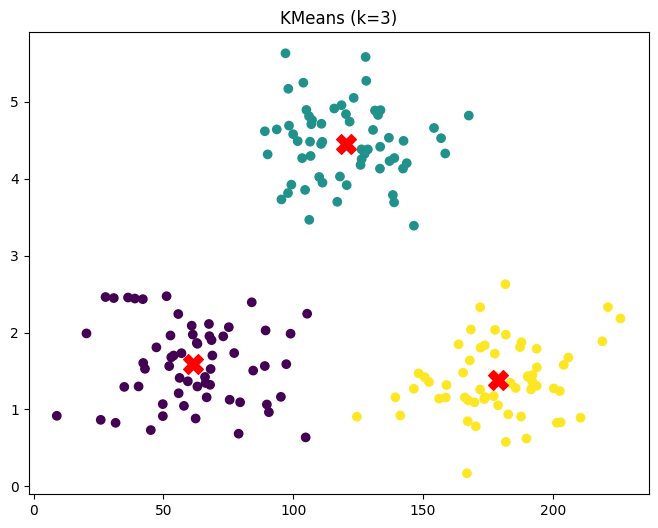

0.6995782327658537

In [3]:
kmeans3 = KMeans(n_clusters=3, random_state=42)
labels3 = kmeans3.fit_predict(X_scaled)

df1['cluster3'] = labels3

plt.scatter(df1['x'], df1['y'], c=labels3, cmap='viridis')
centers = scaler.inverse_transform(kmeans3.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], s=200, c='red', marker='X')
plt.title('KMeans (k=3)')
plt.show()

sil3 = silhouette_score(X_scaled, labels3)
sil3

## Повтор для k = 2 и k = 4

In [4]:
results = {}
for k in [2,3,4]:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    results[k] = sil

results

{2: 0.4870684472213428, 3: 0.6995782327658537, 4: 0.5575545795725936}

**Выводы:**

Показатель силуэта достигает максимального значения при k = 3. Это говорит о том, что разбиение на три кластера обеспечивает наилучшее сочетание внутрикластерной компактности и межкластерной разделённости. При k = 2 данные объединяются слишком грубо, а при k = 4 возникает избыточное деление, уменьшающее чёткость структуры. Таким образом, оптимальным числом кластеров для синтетического набора данных является k = 3.

## Метод локтя

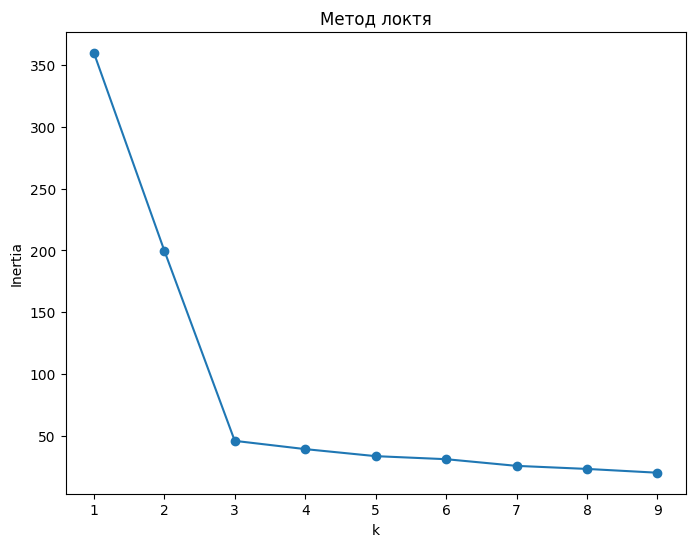

In [5]:
inertia_vals = []
for k in range(1,10):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia_vals.append(km.inertia_)

plt.plot(range(1,10), inertia_vals, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Метод локтя')
plt.show()

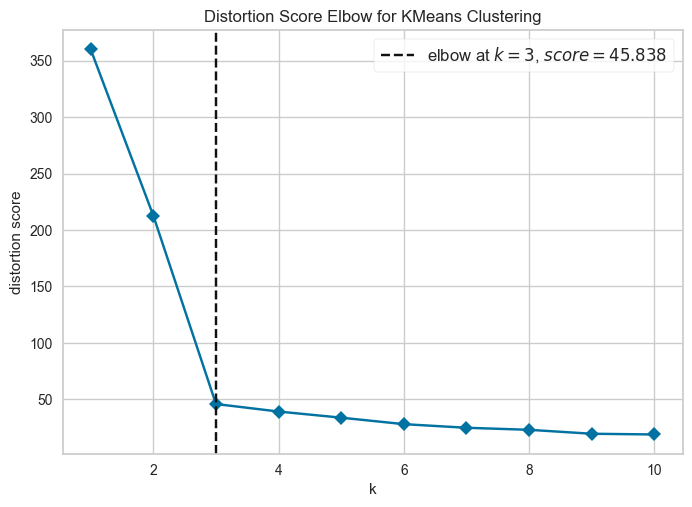

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=0)

visualizer = KElbowVisualizer(model, k=(1,11), timings=False)
visualizer.fit(X_scaled)
visualizer.show()

**Выводы:**

Построенный график показывает выраженный излом в области k = 3. После трёх кластеров уменьшение значения критерия происходит значительно медленнее, что подтверждает наличие характерной структуры именно с тремя естественными группами.

# Часть 2 — Набор данных bank_loan_default.csv

In [7]:
import pandas as pd
df = pd.read_csv('C:\\Users\\Максим\\Desktop\\учеба вуз\\АД\\bank_loan_default.csv')
df.head()

,age,annual_income,employment_type,education,loan_amount,interest_rate_pct,term_months,credit_score,num_open_accounts,delinquency_30d,residence_type,Default
0,42,57272.0,Self-Employed,Masters,8516.0,5.85,48,730.0,10,No,Own,0
1,51,45786.0,Salaried,Masters,13760.0,9.97,36,677.0,7,No,Mortgage,0
2,69,42359.0,Salaried,Bachelors,2569.0,13.75,48,624.0,2,No,Own,0
3,65,50709.0,Self-Employed,Masters,13204.0,8.70,48,698.0,3,No,Rent,0
4,30,46272.0,Salaried,HS,7700.0,7.53,48,532.0,7,No,Rent,0


## Предобработка данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3041 entries, 0 to 3040
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3041 non-null   int64  
 1   annual_income      3041 non-null   float64
 2   employment_type    3041 non-null   object 
 3   education          3041 non-null   object 
 4   loan_amount        3041 non-null   float64
 5   interest_rate_pct  3041 non-null   float64
 6   term_months        3041 non-null   int64  
 7   credit_score       3041 non-null   float64
 8   num_open_accounts  3041 non-null   int64  
 9   delinquency_30d    3041 non-null   object 
 10  residence_type     3041 non-null   object 
 11  Default            3041 non-null   int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 285.2+ KB


Данные о кредитах:

age — возраст заёмщика (лет), числовой.

annual_income — годовой доход, USD/год, числовой (широкий диапазон).

employment_type — тип занятости: Salaried / Self-Employed / Unemployed,
категориальный.

education — образование: HS / Bachelors / Masters / PhD, категориальный.

loan_amount — сумма кредита, USD, числовой (широкий диапазон).

interest_rate_pct — процентная ставка по кредиту, % годовых, числовой.

term_months — срок кредита, месяцев (набор фиксированных значений:
24/36/48/60/72), числовой/категориальный.

credit_score — кредитный скор (от 300 до 850), числовой.

num_open_accounts — число открытых кредитных счетов, целочисленный
счётчик.

delinquency_30d — просрочка платежа 30 дней: Yes / No, категориальный.

residence_type — жильё: Own / Rent / Mortgage, категориальный.

Default — целевой класс: 1 — дефолт по кредиту, 0 — нет.

In [9]:
df['term_months'] = df['term_months'].astype('object')
cat_cols = ['employment_type', 'education', 'term_months', 'delinquency_30d', 'residence_type']
num_cols = [c for c in df.columns if c not in cat_cols + ['Default']]

num_cols

['age',
 'annual_income',
 'loan_amount',
 'interest_rate_pct',
 'credit_score',
 'num_open_accounts']

## Диаграммы рассеяния

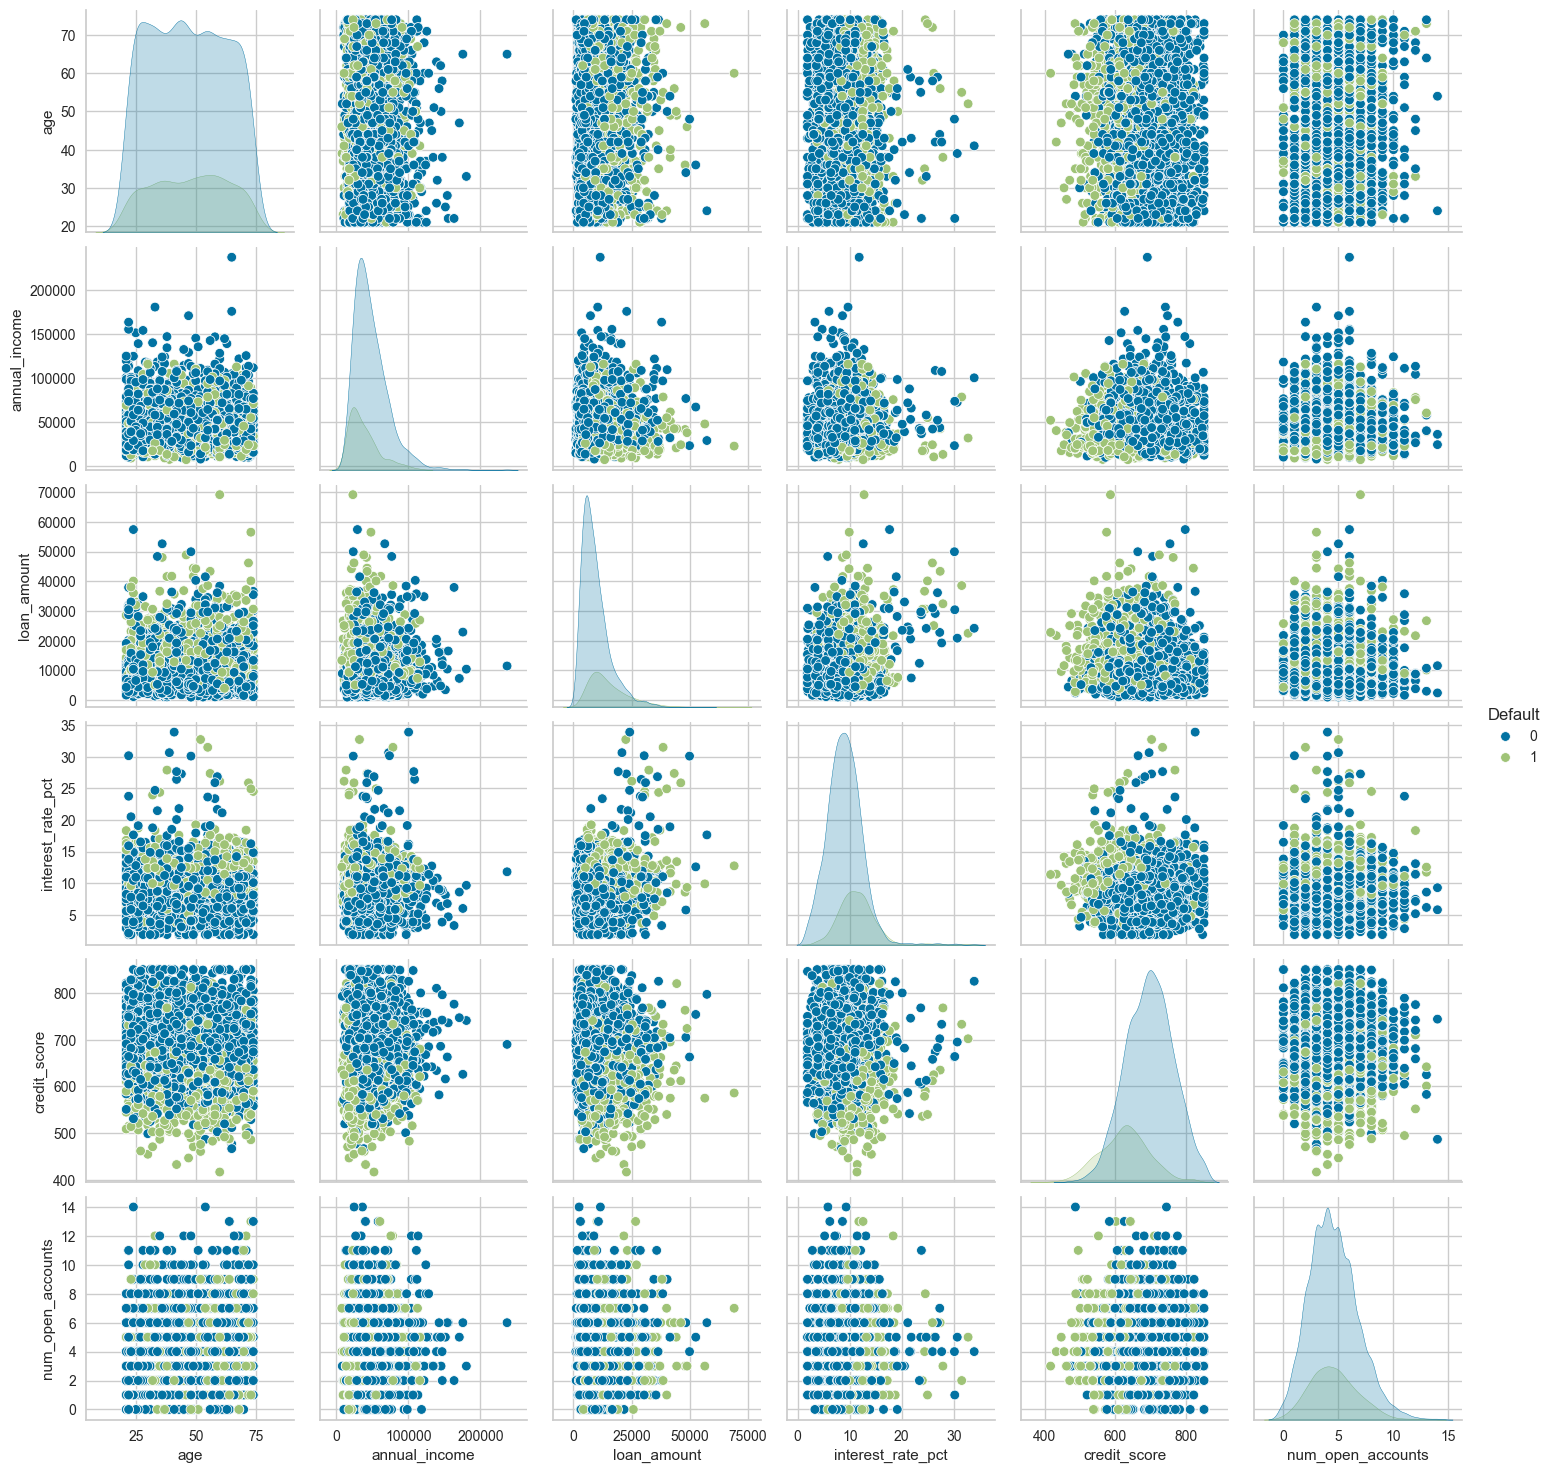

In [10]:
import seaborn as sns
sns.pairplot(df[num_cols + ['Default']], hue='Default', diag_kind='kde')
plt.show()

## Стандартизация числовых данных

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])
X_scaled[:5]

array([[-3.26255352e-01,  4.89032122e-01, -2.93528077e-01,
        -1.01799205e+00,  6.67669832e-01,  2.50694585e+00],
       [ 2.50758071e-01,  1.68941365e-03,  4.16689533e-01,
         1.51503308e-01, -5.84066945e-02,  1.12801983e+00],
       [ 1.40478492e+00, -1.43715728e-01, -1.09895602e+00,
         1.22448691e+00, -7.84483221e-01, -1.17019021e+00],
       [ 1.14833451e+00,  2.10568758e-01,  3.41388047e-01,
        -2.08996474e-01,  2.29284005e-01, -7.10548201e-01],
       [-1.09560658e+00,  2.23100436e-02, -4.04042488e-01,
        -5.41110447e-01, -2.04484247e+00,  1.12801983e+00]])

## Подбор оптимального k (KMeans)

In [12]:
scores = {}
for k in range(2,11):
    km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    labels = km.labels_
    sil = silhouette_score(X_scaled, labels)
    scores[k] = sil

scores

{2: 0.13591705616382413,
 3: 0.1416851381552817,
 4: 0.14076590569691128,
 5: 0.1292633166431947,
 6: 0.13344225632159598,
 7: 0.1265283128990342,
 8: 0.12093398361559632,
 9: 0.12267237883689691,
 10: 0.11974090506854955}

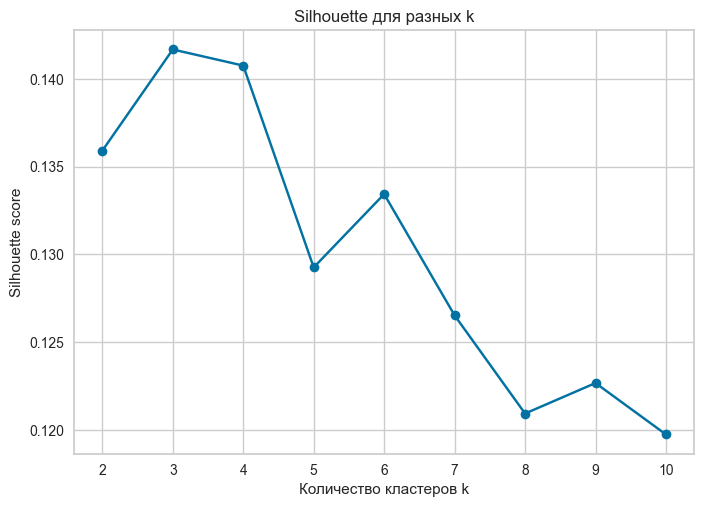

In [13]:
plt.plot(list(scores.keys()), list(scores.values()), marker='o')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette score')
plt.title('Silhouette для разных k')
plt.show()

## Итоговая модель KMeans

In [14]:
best_k = max(scores, key=scores.get)
best_k

3

In [15]:
kmeans_final = KMeans(n_clusters=best_k, random_state=0)
labels_final = kmeans_final.fit_predict(X_scaled)

df['cluster'] = labels_final
df.groupby('cluster')[num_cols].mean()


,age,annual_income,loan_amount,interest_rate_pct,credit_score,num_open_accounts
cluster,,,,,,
0,61.350746,46369.295191,8438.063847,8.797894,688.159204,4.764511
1,33.573808,46621.180924,8265.706132,9.100104,694.610901,4.495079
2,48.359922,42035.392996,22164.670817,11.798058,630.780156,4.163424


## Метрики качества кластеризации

In [16]:
from sklearn import metrics

metrics_results = {
    'silhouette': silhouette_score(X_scaled, labels_final),
    'ARI': metrics.adjusted_rand_score(df['Default'], labels_final),
    'AMI': metrics.adjusted_mutual_info_score(df['Default'], labels_final),
    'FMI': metrics.fowlkes_mallows_score(df['Default'], labels_final),
    'V-measure': metrics.v_measure_score(df['Default'], labels_final)
}

metrics_results

{'silhouette': 0.1416851381552817,
 'ARI': 0.1120770613374959,
 'AMI': 0.09474462989283815,
 'FMI': 0.5634105212672075,
 'V-measure': 0.09513297787183422}

# Агломеративная кластеризация

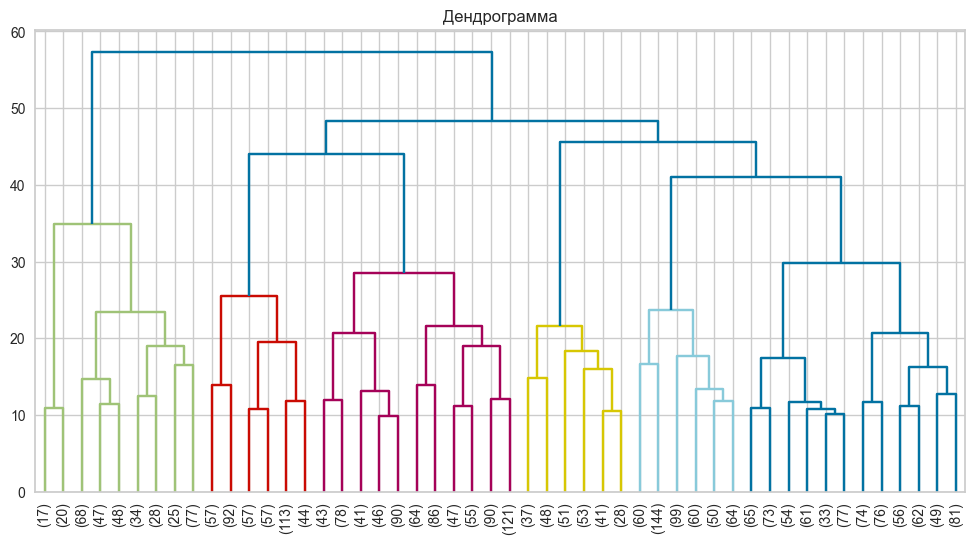

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(12,6))
dendrogram(linked,
           truncate_mode='lastp',
           p=50,
           show_leaf_counts=True,  # показывать количество листьев в скобках
           leaf_rotation=90,       # повернуть подписи на 90 градусов
           leaf_font_size=10,       # размер шрифта подписей
           )   # show_contracted=True показывать сокращенные ветви
plt.title('Дендрограмма')
plt.show()

## Кластеризация по агломеративному методу

In [18]:
optimal_k = 3

In [19]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=optimal_k)
labels_agg = agg.fit_predict(X_scaled)

df['cluster_agg'] = labels_agg


In [20]:
df.groupby('cluster_agg')[num_cols].mean()

,age,annual_income,loan_amount,interest_rate_pct,credit_score,num_open_accounts
cluster_agg,,,,,,
0,54.671123,49256.209893,8782.432219,9.053505,704.802807,4.302807
1,45.747253,43285.708791,24955.634615,10.902901,665.041209,4.563187
2,37.897544,42058.301439,8692.272650,9.469094,656.445385,4.848434


In [21]:
from sklearn import metrics

metrics_agg = {
    'silhouette': metrics.silhouette_score(X_scaled, labels_agg),
    'ARI': metrics.adjusted_rand_score(df['Default'], labels_agg),
    'AMI': metrics.adjusted_mutual_info_score(df['Default'], labels_agg),
    'FMI': metrics.fowlkes_mallows_score(df['Default'], labels_agg),
    'V-measure': metrics.v_measure_score(df['Default'], labels_agg)
}

metrics_agg


{'silhouette': 0.08149433116662708,
 'ARI': 0.07502686447732167,
 'AMI': 0.042750312123087775,
 'FMI': 0.5623361807835635,
 'V-measure': 0.04317753482306022}

**Метрики при разном количестве кластеров:**

метрики при выборе 3 кластеров
- 'silhouette': 0.08149433116662708,
- 'ARI': 0.07502686447732167,
- 'AMI': 0.042750312123087775,
- 'FMI': 0.5623361807835635,
- 'V-measure': 0.04317753482306022

метрики при выборе 5 кластеров
- 'silhouette': 0.07521954475574781,
- 'ARI': 0.046866373496295376,
- 'AMI': 0.03376842870668728,
- 'FMI': 0.457940699554776,
- 'V-measure': 0.03442002469010543

метрики при выборе 6 кластеров
 - 'silhouette': 0.0689584691479699,
 - 'ARI': 0.025912746197384977,
 - 'AMI': 0.04026836435523272,
 - 'FMI': 0.3803684782935322,
 - 'V-measure': 0.04097875915871389